In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import json
import cv2
import matplotlib
import matplotlib.pyplot as plt
from plot_gps import *
from tqdm import tqdm


In [2]:
map_path="./map/high_res_full_UPB_standard.png"
csv_path="./map/high_res_full_UPB_standard.csv"
map_viewer = ImageWgsHandler(map_path, csv_path)

# get jsons files
path_jsons = "PATH/TO/RAW/DATASET/DIR (has to contains .json files)"
jsons = os.listdir(path_jsons)
jsons = [file for file in jsons if file.endswith(".json")]


Es, Ns = [], []
for path_file in tqdm(jsons):
    with open(os.path.join(path_jsons, path_file)) as f:
        info = json.load(f)

    gps_unique = pd.DataFrame(info["locations"])
    easting, northing = gps_unique.easting.values, gps_unique.northing.values
    
    Ns += list(northing)
    Es += list(easting)
    

100%|██████████| 408/408 [01:03<00:00,  6.40it/s]


In [3]:
def split_squares(S):
    Nmin, Nmax = S[0]
    Emin, Emax = S[1]
    
    # get central point
    Nctrl, Ectrl = (Nmin + Nmax)/2, (Emin + Emax)/2

    # define the 4 squares
    S1 = [(Nmin, Nctrl), (Emin, Ectrl)]
    S2 = [(Nmin, Nctrl), (Ectrl, Emax)]
    S3 = [(Nctrl, Nmax), (Emin, Ectrl)]
    S4 = [(Nctrl, Nmax), (Ectrl, Emax)]
    return [S1, S2, S3, S4]

In [4]:
def in_square(easting, northing, S):
    cond1 = (easting >= S[1][0]) & (easting <= S[1][1])
    cond2 = (northing >= S[0][0]) & (northing <= S[0][1])
    cond = cond1 & cond2
    return np.mean(cond)        

In [5]:
def get_procs(S, jsons):
    files = [[], [], [], []]
    counts = [0, 0, 0, 0]
    Ss = split_squares(S)

    for file_name in tqdm(jsons):
        # read josn
        with open(os.path.join(path_jsons, file_name)) as f:
            info = json.load(f)

        # get coordinates
        gps_unique = pd.DataFrame(info["locations"])
        easting, northing = gps_unique.easting.values, gps_unique.northing.values

        # compute overlap with each square
        procs = []
        for S in Ss:
            procs.append(in_square(easting, northing, S))

        index = np.argmax(procs)
        counts[index] += 1
        files[index].append(file_name)
        
    return Ss, counts, files

In [6]:
# get extreme points
Nmin, Nmax = np.min(Ns), np.max(Ns)
Emin, Emax = np.min(Es), np.max(Es)
S = [(Nmin, Nmax), (Emin, Emax)]
Ss, counts, files = get_procs(S, jsons)
print(counts)

100%|██████████| 408/408 [00:26<00:00, 15.48it/s]

[195, 163, 7, 43]


In [7]:
Ss2, counts2, files2 = get_procs(Ss[1], files[1])
print(counts2)

100%|██████████| 163/163 [00:10<00:00, 15.90it/s]

[66, 0, 66, 31]


In [8]:
test_jsons = set(files[2] + files[3] + files2[3])
train_jsons = set(jsons).difference(test_jsons)

test_jsons = list(test_jsons)
train_jsons = list(train_jsons)
print("Train: %d, Test: %d\n" % (len(train_jsons), len(test_jsons)))

Train: 327, Test: 81



In [10]:
def plot_traj(jsons, train=True):
    Es, Ns = [], []
    for path_file in tqdm(jsons):
        with open(os.path.join(path_jsons, path_file)) as f:
            info = json.load(f)

        gps_unique = pd.DataFrame(info["locations"])
        easting, northing = gps_unique.easting.values, gps_unique.northing.values

        Ns += list(northing)
        Es += list(easting)
        
    Ns = np.array(Ns)
    Es = np.array(Es)
    
    # plot coordinates
    map_path="./map/high_res_full_UPB_standard.png"
    csv_path="./map/high_res_full_UPB_standard.csv"
    map_viewer = ImageWgsHandler(map_path, csv_path)
    rows, cols = map_viewer.get_image_coord(Es, Ns)
    
    map_image = map_viewer.map_image.copy()
    color = (255, 0, 0) if train else (0, 0, 255)
    
    for i in tqdm(range(len(rows))):
        center = (int(cols[i]), int(rows[i]))
        map_image = cv2.circle(map_image, center, radius=20, color=color, thickness=-1)
    
    cv2.imwrite("%s.png" % (os.path.join("imgs", ("train" if train else "test"))), map_image)

In [11]:
# plot train
plot_traj(train_jsons, train=True)

100%|██████████| 1513267/1513267 [00:05<00:00, 267248.18it/s]


In [12]:
# plot test
plot_traj(test_jsons, train=False)

100%|██████████| 380491/380491 [00:01<00:00, 254097.58it/s]


In [13]:
# export train & test split
train_scenes = [file[:-5] for file in train_jsons]
test_scenes = [file[:-5] for file in test_jsons]

with open(os.path.join("split", "train_scenes.txt"), "wt") as fout:
    fout.write("\n".join(train_scenes))

with open(os.path.join("split", "test_scenes.txt"), "wt") as fout:
    fout.write("\n".join(test_scenes))

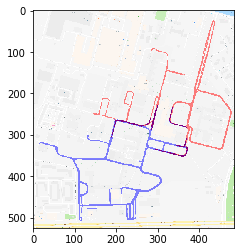

In [23]:
# combine train & test to check overlap
train = cv2.imread("imgs/train.png")
test = cv2.imread("imgs/test.png")

cmb = train//2 + test//2
cv2.imwrite("imgs/train_test_split.png", cmb)

small_cmb = cv2.resize(cmb, dsize=None, fx=0.05, fy=0.05)
plt.imshow(small_cmb[...,::-1])
plt.show()